In [ ]:
import sys, os, glob, time, imageio
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import torch
import torchvision.utils as vutils
import torchvision.transforms as transforms
from keras import models, layers, optimizers
from keras.models import Sequential
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import tensorflow as tf

Using TensorFlow backend.


In [ ]:
root_path='/kaggle/input/tb-images/'
xray_tb=os.listdir(root_path+'tb_gamma_adjusted/')
print(len(xray_tb))

439


In [ ]:
 def _time(start, end):
    if (end-start)<60:
        wall_time = f'{round((end-start),2)}sec'
    elif (end-start)>=3600:
        wall_time = f'{int((end-start)/3600)}h {int(((end-start)%3600)/60)}min {round((end-start)%60,2)}sec'
    else:
        wall_time = f'{int((end-start)/60)}min {round((end-start)%60,2)}sec'
    return wall_time

In [ ]:
nrows, ncols = 4, 7
plt.figure(figsize=(16,10))
for idx, name in enumerate(xray_tb[:nrows*ncols]):
    plt.subplot(nrows, ncols, idx+1)
    img = Image.open(root_path+'tb_gamma_adjusted/'+name)
    img = img.resize(size=(128, 128), resample=Image.ANTIALIAS, box=None)
    plt.imshow(img)
    plt.title(name[:-5], fontsize=9)
    plt.axis('off')

NameError: name 'plt' is not defined

In [ ]:
def get_data(data_path, dim=(128, 128), rand_shuffle=True):
    start = time.time()
    imgs_data = []
    sample_size = len(data_path)
    for idx, im_path in enumerate(data_path):
        if idx%(sample_size//10)==0:
            print('Processing index {:05d} of {:05d} ==> {:03d}%'\
                  .format(idx, sample_size, round(100*idx/sample_size)))
        img = img_to_array(load_img(im_path, target_size = dim))
        imgs_data.append(img)


    imgs_data = np.array(imgs_data).astype('float32')

    imgs_data = imgs_data/255.

    if rand_shuffle:
        idx = np.arange(imgs_data.shape[0])
        np.random.shuffle(idx)
        imgs_data = imgs_data[idx,:,:,:]

    print(f"Calculations are done in {_time(start, time.time())}")
    return imgs_data


In [ ]:
X_tb = get_data(xray_tb_path)

Starting for PNEUMONIA X-Ray images ...
Processing index 00000 of 00439 ==> 000%
Processing index 00043 of 00439 ==> 010%
Processing index 00086 of 00439 ==> 020%
Processing index 00129 of 00439 ==> 029%
Processing index 00172 of 00439 ==> 039%
Processing index 00215 of 00439 ==> 049%
Processing index 00258 of 00439 ==> 059%
Processing index 00301 of 00439 ==> 069%
Processing index 00344 of 00439 ==> 078%
Processing index 00387 of 00439 ==> 088%
Processing index 00430 of 00439 ==> 098%
Hey! the calculations are done in 6.69sec


In [ ]:
def define_grid(data_images, nrows=4, ncols=5, plot_grid=True):

    start = time.time()
    # Number of GPUs available. Use 0 for CPU mode.
    ngpu = 1
    # Decide which device we want to run on
    device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    # Rearange the shaphe of the data
    data_transp = [np.transpose(data_images[i,:,:]) for i in range(data_images[:nrows*ncols].shape[0])]
    # From to torch type for the grid
    data_transp = torch.Tensor(data_transp)
    print(f'The shape is reordered from {data_images.shape[1:]} to {data_transp.shape[1:]} in {_time(start, time.time())}')

    # Make the grid
    grid_images = np.transpose(
        vutils.make_grid(
            data_transp.to(device)[:nrows*ncols],
            nrow=nrows,
            padding=2,
            normalize=True,
            scale_each=True,
            pad_value=1,
        ).cpu(), axes=(2,1,0))

    # Show the output grid
    if plot_grid:
        plt.figure(figsize=(12,12))
        plt.axis("off")
        plt.title(f'Grid of {nrows*ncols} real images', fontsize=27)
        plt.imshow(grid_images)

    return grid_images

grid_X_pneumonial = define_grid(X_tb, plot_grid=False)

The shape is reordered from (128, 128, 3) to torch.Size([3, 128, 128]) in 0.27sec


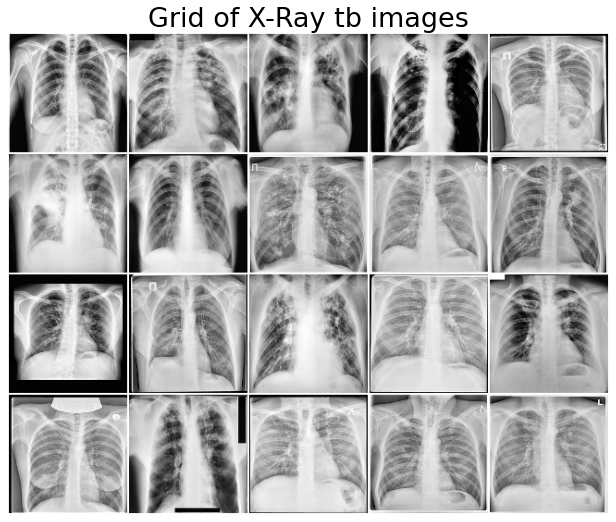

In [ ]:
fig, (ax1)= plt.subplots(nrows=1, ncols=1, figsize=(19, 8))

ax1.imshow(grid_X_pneumonial); ax1.axis('off')
ax1.set_title(label = 'Grid of X-Ray tb images', fontsize = 27)

plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=[0, 0.03, 1, 0.95])

## Set the parameters  

In [ ]:
# Number of training epochs
n_epoch = 5000

# Batch size during training
batch_size = 128

# Size of z latent vector (i.e. size of generator input)
latent_dim = 100

# Spatial size of training images. All images will be resized to this size
cols, rows = 128, 128

# Number of channels in the training images. For RGB color images this is 3
channels = 3
dim = cols, rows # height, width
in_shape = (cols, rows, channels) # height, width, color

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# plot ncols images in row and nrows images in colomn
nrows, ncols = 3, 4


# Discriminator

In [ ]:
def define_discriminator(in_shape=(128,128,3)):
    model = models.Sequential()
    # normal
    model.add(layers.Conv2D(128, (5,5), padding='same', input_shape=in_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    # downsample to 64x64
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # downsample to 32x32
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # downsample to 16x16
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # downsample to 8x8
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # classifier
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))
    # compile model
    opt = optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

## Generator

In [ ]:
def define_generator(latent_dim):
    model = models.Sequential()
    # foundation for 8x8 feature maps
    n_nodes = 128*8*8
    model.add(layers.Dense(n_nodes, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((8, 8, 128)))
    # upsample to 16x16
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 128x128
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # output layer 128x128x3
    model.add(layers.Conv2D(3, (5,5), activation='tanh', padding='same'))
    return model

#input of G
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim*n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

## Define GAN model

In [ ]:
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = models.Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# retrive real samples
def get_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # set 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

# create and save a plot of generated images
def show_generated(generated, epoch, nrows=4, ncols=5):
    #[-1,1] -> [0,1]
    #generated = (generated+1)/2
    #generated = (generated[:ncols*nrows]*127.5)+127.5
    #generated = generated*255
    plt.figure(figsize=(10,10))
    for idx in range(nrows*ncols):
        plt.subplot(nrows, ncols, idx+1)
        plt.imshow(generated[idx])
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1))
    plt.show()

# evaluate the discriminator and plot generated images
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = get_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('> Accuracy at epoch %d [real: %.0f%%, fake: %.0f%%]'%(epoch+1, acc_real*100, acc_fake*100))
    # show plot
    show_generated(x_fake, epoch)

def plot_loss(loss):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training", fontsize=20)
    plt.plot(loss[0], label="D_real")
    plt.plot(loss[1], label="D_fake")
    plt.plot(loss[2], label="G")
    plt.xlabel("Iteration", fontsize=20); plt.ylabel("Loss", fontsize=20)
    plt.legend(); plt.show()

In [ ]:
def save_models(epoch, g_model, d_model, gan_model):
    g_model.save_weights(f'generator_{epoch}_epochs.h5')
    d_model.save_weights(f'discriminator_{epoch}_epochs.h5')
    gan_model.save_weights(f'gan_{epoch}_epochs.h5')

# Train the models

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim=100, n_epochs=100, n_batch=128, start_epoch=0):

    start = time.time()
    bat_per_epo = int(dataset.shape[0]/n_batch)
    half_batch = int(n_batch/2)
    loss1, loss2, loss3 = [], [], []
    fake_liste = []

    # manually enumerate epochs
    print('Training Start...')
    for i in range(start_epoch, start_epoch+n_epochs):
        start1 = time.time()
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = get_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            loss1.append(d_loss1); loss2.append(d_loss2); loss3.append(g_loss)

        print('Epoch: {:03d}/{:03d}, Loss: [D_real = {:2.3f}, D_fake = {:2.3f}, G = {:2.3f}], time: {:s}'\
              .format(i+1,start_epoch+n_epochs,d_loss1,d_loss2,g_loss, _time(start1,time.time())))
        # evaluate the model performance
        if (epoch + 1) % 100 == 0:
            # Save and show generated images
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

        if (epoch + 1) % 1000 == 0:
            save_models(epoch, g_model, d_model, gan_model)

    print('Total time for training {} epochs is {} sec'.format(n_epochs, _time(start, time.time())))

    # Show loss curves
    loss = (loss1, loss2, loss3)
    plot_loss(loss)

In [ ]:
discriminator = define_discriminator()
generator = define_generator(latent_dim)

# create the gan
gan = define_gan(generator, discriminator)

In [ ]:
def load_models(g_model, d_model, gan_model, epoch):
    g_model.load_weights(f'/kaggle/input/gan/tensorflow2/default/1/generator_1000_epochs (1).h5')
    d_model.load_weights(f'/kaggle/input/gan/tensorflow2/default/1/discriminator_1000_epochs (1).h5')
    gan_model.load_weights(f'/kaggle/input/gan/tensorflow2/default/1/gan_1000_epochs.h5')

load_models(generator, discriminator, gan, epoch=1000)

Training Start...


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 001/5000, Loss: [D_real = 0.090, D_fake = 0.721, G = 0.671], time: 10.61sec
Epoch: 002/5000, Loss: [D_real = 0.013, D_fake = 0.804, G = 0.659], time: 2.62sec
Epoch: 003/5000, Loss: [D_real = 0.303, D_fake = 0.983, G = 0.606], time: 2.61sec
Epoch: 004/5000, Loss: [D_real = 0.549, D_fake = 0.821, G = 0.719], time: 2.61sec
Epoch: 005/5000, Loss: [D_real = 0.607, D_fake = 0.680, G = 0.984], time: 2.61sec
Epoch: 006/5000, Loss: [D_real = 0.425, D_fake = 0.689, G = 0.808], time: 2.61sec
Epoch: 007/5000, Loss: [D_real = 0.019, D_fake = 0.659, G = 0.789], time: 2.61sec
Epoch: 008/5000, Loss: [D_real = 0.003, D_fake = 0.551, G = 1.197], time: 2.61sec
Epoch: 009/5000, Loss: [D_real = 0.000, D_fake = 0.650, G = 0.920], time: 2.61sec
Epoch: 010/5000, Loss: [D_real = 0.001, D_fake = 0.072, G = 4.061], time: 2.61sec
Epoch: 011/5000, Loss: [D_real = 0.000, D_fake = 0.394, G = 16.511], time: 2.61sec
Epoch: 012/5000, Loss: [D_real = 0.000, D_fake = 5.539, G = 21.077], time: 2.61sec
Epoch: 013/50

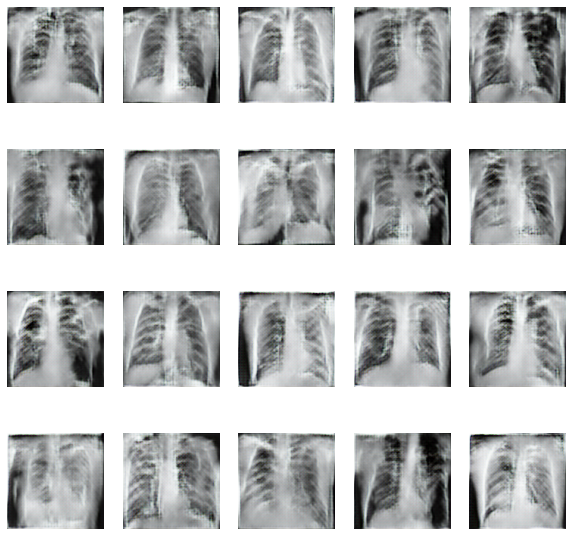

Epoch: 501/5000, Loss: [D_real = 0.277, D_fake = 0.204, G = 2.919], time: 2.61sec
Epoch: 502/5000, Loss: [D_real = 0.307, D_fake = 0.383, G = 3.091], time: 2.61sec
Epoch: 503/5000, Loss: [D_real = 0.211, D_fake = 0.308, G = 3.277], time: 2.61sec
Epoch: 504/5000, Loss: [D_real = 0.346, D_fake = 0.256, G = 2.848], time: 2.61sec
Epoch: 505/5000, Loss: [D_real = 0.281, D_fake = 0.333, G = 3.919], time: 2.6sec
Epoch: 506/5000, Loss: [D_real = 0.407, D_fake = 0.200, G = 2.546], time: 2.61sec
Epoch: 507/5000, Loss: [D_real = 0.238, D_fake = 0.151, G = 3.333], time: 2.61sec
Epoch: 508/5000, Loss: [D_real = 0.393, D_fake = 0.615, G = 3.899], time: 2.61sec
Epoch: 509/5000, Loss: [D_real = 0.343, D_fake = 0.325, G = 2.832], time: 2.61sec
Epoch: 510/5000, Loss: [D_real = 0.409, D_fake = 0.259, G = 2.874], time: 2.61sec
Epoch: 511/5000, Loss: [D_real = 0.458, D_fake = 0.400, G = 3.255], time: 2.61sec
Epoch: 512/5000, Loss: [D_real = 0.216, D_fake = 0.243, G = 3.230], time: 2.61sec
Epoch: 513/5000, 

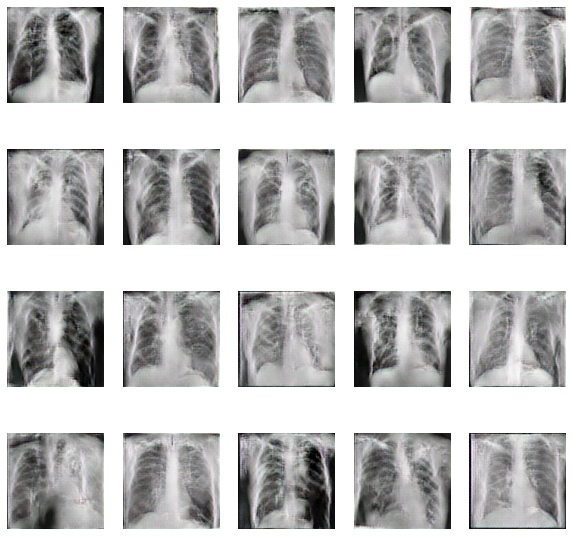

Epoch: 1001/5000, Loss: [D_real = 0.301, D_fake = 0.361, G = 2.682], time: 2.61sec
Epoch: 1002/5000, Loss: [D_real = 0.216, D_fake = 0.221, G = 2.968], time: 2.61sec
Epoch: 1003/5000, Loss: [D_real = 0.386, D_fake = 0.264, G = 2.563], time: 2.6sec
Epoch: 1004/5000, Loss: [D_real = 0.281, D_fake = 0.454, G = 2.886], time: 2.61sec
Epoch: 1005/5000, Loss: [D_real = 0.223, D_fake = 0.350, G = 2.923], time: 2.61sec
Epoch: 1006/5000, Loss: [D_real = 0.182, D_fake = 0.169, G = 2.707], time: 2.61sec
Epoch: 1007/5000, Loss: [D_real = 0.267, D_fake = 0.471, G = 3.212], time: 2.61sec
Epoch: 1008/5000, Loss: [D_real = 0.283, D_fake = 0.328, G = 2.515], time: 2.61sec
Epoch: 1009/5000, Loss: [D_real = 0.154, D_fake = 0.364, G = 3.379], time: 2.61sec
Epoch: 1010/5000, Loss: [D_real = 0.146, D_fake = 0.204, G = 3.345], time: 2.61sec
Epoch: 1011/5000, Loss: [D_real = 0.231, D_fake = 0.358, G = 3.244], time: 2.61sec
Epoch: 1012/5000, Loss: [D_real = 0.208, D_fake = 0.218, G = 2.904], time: 2.61sec
Epoch

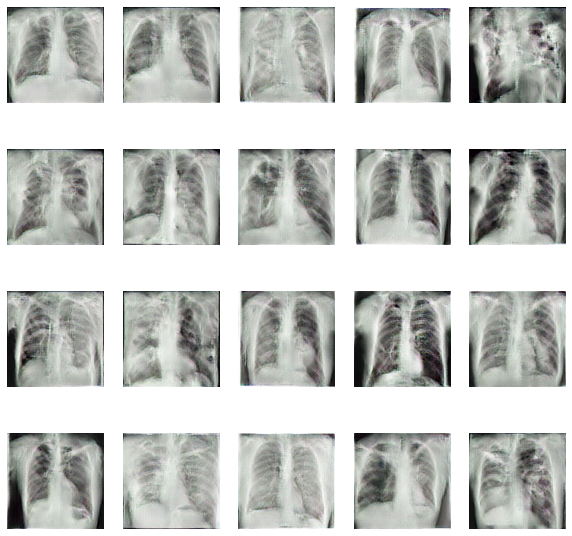

Epoch: 1501/5000, Loss: [D_real = 0.066, D_fake = 0.041, G = 5.094], time: 2.61sec
Epoch: 1502/5000, Loss: [D_real = 0.050, D_fake = 0.040, G = 5.195], time: 2.61sec
Epoch: 1503/5000, Loss: [D_real = 0.051, D_fake = 0.053, G = 4.712], time: 2.6sec
Epoch: 1504/5000, Loss: [D_real = 0.102, D_fake = 0.188, G = 5.874], time: 2.61sec
Epoch: 1505/5000, Loss: [D_real = 0.085, D_fake = 0.116, G = 5.031], time: 2.61sec
Epoch: 1506/5000, Loss: [D_real = 0.055, D_fake = 0.091, G = 5.628], time: 2.61sec
Epoch: 1507/5000, Loss: [D_real = 0.072, D_fake = 0.089, G = 5.586], time: 2.61sec
Epoch: 1508/5000, Loss: [D_real = 0.014, D_fake = 0.118, G = 6.386], time: 2.6sec
Epoch: 1509/5000, Loss: [D_real = 0.050, D_fake = 0.074, G = 6.800], time: 2.61sec
Epoch: 1510/5000, Loss: [D_real = 0.070, D_fake = 0.048, G = 5.583], time: 2.61sec
Epoch: 1511/5000, Loss: [D_real = 0.066, D_fake = 0.027, G = 5.130], time: 2.6sec
Epoch: 1512/5000, Loss: [D_real = 0.096, D_fake = 0.089, G = 5.060], time: 2.61sec
Epoch: 

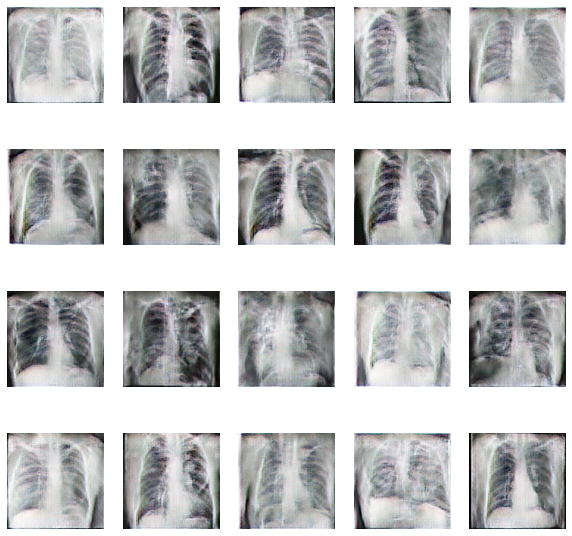

Epoch: 2001/5000, Loss: [D_real = 0.210, D_fake = 0.187, G = 3.896], time: 2.61sec
Epoch: 2002/5000, Loss: [D_real = 0.125, D_fake = 0.193, G = 3.873], time: 2.61sec
Epoch: 2003/5000, Loss: [D_real = 0.191, D_fake = 0.301, G = 4.131], time: 2.61sec
Epoch: 2004/5000, Loss: [D_real = 0.121, D_fake = 0.215, G = 3.513], time: 2.61sec
Epoch: 2005/5000, Loss: [D_real = 0.193, D_fake = 0.150, G = 3.750], time: 2.61sec
Epoch: 2006/5000, Loss: [D_real = 0.106, D_fake = 0.171, G = 4.058], time: 2.61sec
Epoch: 2007/5000, Loss: [D_real = 0.141, D_fake = 0.199, G = 3.654], time: 2.61sec
Epoch: 2008/5000, Loss: [D_real = 0.158, D_fake = 0.159, G = 3.605], time: 2.61sec
Epoch: 2009/5000, Loss: [D_real = 0.119, D_fake = 0.324, G = 3.875], time: 2.61sec
Epoch: 2010/5000, Loss: [D_real = 0.130, D_fake = 0.206, G = 3.833], time: 2.61sec
Epoch: 2011/5000, Loss: [D_real = 0.170, D_fake = 0.249, G = 3.868], time: 2.61sec
Epoch: 2012/5000, Loss: [D_real = 0.157, D_fake = 0.367, G = 4.140], time: 2.6sec
Epoch

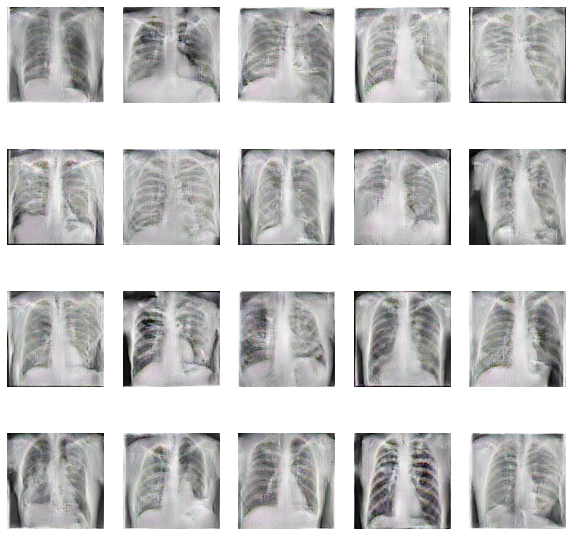

Epoch: 2501/5000, Loss: [D_real = 0.042, D_fake = 0.040, G = 6.363], time: 2.62sec
Epoch: 2502/5000, Loss: [D_real = 0.049, D_fake = 0.037, G = 6.391], time: 2.62sec
Epoch: 2503/5000, Loss: [D_real = 0.042, D_fake = 0.091, G = 6.537], time: 2.62sec
Epoch: 2504/5000, Loss: [D_real = 0.029, D_fake = 0.016, G = 6.347], time: 2.61sec
Epoch: 2505/5000, Loss: [D_real = 0.041, D_fake = 0.028, G = 6.921], time: 2.61sec
Epoch: 2506/5000, Loss: [D_real = 0.026, D_fake = 0.167, G = 9.004], time: 2.62sec
Epoch: 2507/5000, Loss: [D_real = 0.033, D_fake = 0.098, G = 5.943], time: 2.61sec
Epoch: 2508/5000, Loss: [D_real = 0.093, D_fake = 0.087, G = 6.954], time: 2.62sec
Epoch: 2509/5000, Loss: [D_real = 0.104, D_fake = 0.046, G = 5.878], time: 2.61sec
Epoch: 2510/5000, Loss: [D_real = 0.092, D_fake = 0.147, G = 6.513], time: 2.61sec
Epoch: 2511/5000, Loss: [D_real = 0.028, D_fake = 0.017, G = 6.049], time: 2.61sec
Epoch: 2512/5000, Loss: [D_real = 0.030, D_fake = 0.051, G = 6.800], time: 2.61sec
Epoc

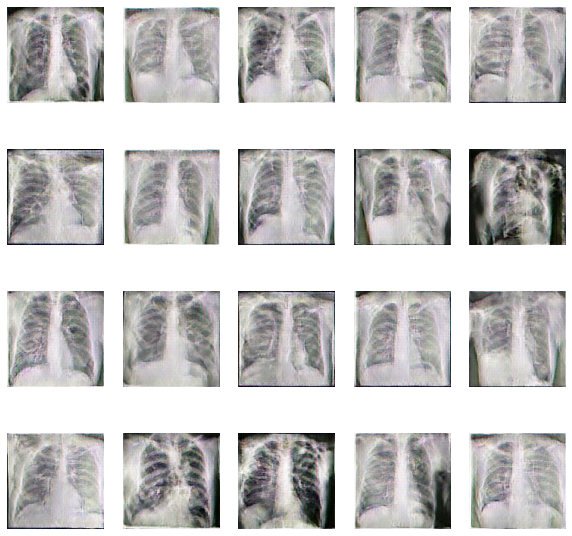

Epoch: 3001/5000, Loss: [D_real = 0.251, D_fake = 0.278, G = 3.016], time: 2.62sec
Epoch: 3002/5000, Loss: [D_real = 0.174, D_fake = 0.305, G = 3.921], time: 2.62sec
Epoch: 3003/5000, Loss: [D_real = 0.125, D_fake = 0.158, G = 3.430], time: 2.61sec
Epoch: 3004/5000, Loss: [D_real = 0.323, D_fake = 0.219, G = 3.233], time: 2.62sec
Epoch: 3005/5000, Loss: [D_real = 0.213, D_fake = 0.199, G = 3.403], time: 2.61sec
Epoch: 3006/5000, Loss: [D_real = 0.268, D_fake = 0.159, G = 3.280], time: 2.62sec
Epoch: 3007/5000, Loss: [D_real = 0.175, D_fake = 0.259, G = 3.248], time: 2.61sec
Epoch: 3008/5000, Loss: [D_real = 0.268, D_fake = 0.267, G = 3.544], time: 2.61sec
Epoch: 3009/5000, Loss: [D_real = 0.164, D_fake = 0.207, G = 3.513], time: 2.62sec
Epoch: 3010/5000, Loss: [D_real = 0.171, D_fake = 0.301, G = 3.388], time: 2.61sec
Epoch: 3011/5000, Loss: [D_real = 0.267, D_fake = 0.223, G = 3.464], time: 2.61sec
Epoch: 3012/5000, Loss: [D_real = 0.121, D_fake = 0.134, G = 3.745], time: 2.62sec
Epoc

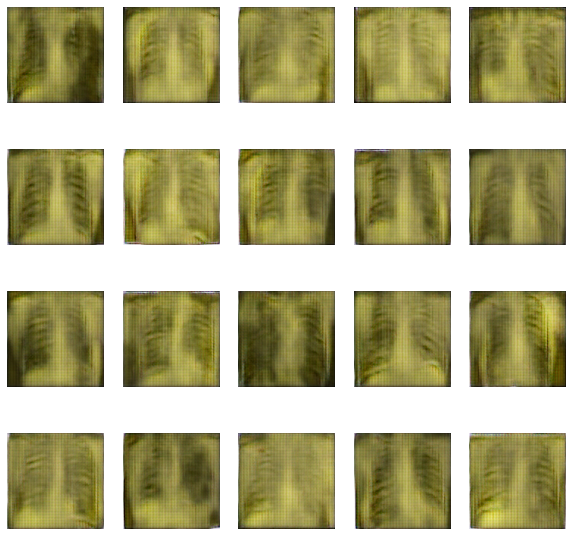

Epoch: 3501/5000, Loss: [D_real = 0.523, D_fake = 1.483, G = 7.150], time: 2.61sec
Epoch: 3502/5000, Loss: [D_real = 0.251, D_fake = 0.777, G = 8.168], time: 2.61sec
Epoch: 3503/5000, Loss: [D_real = 0.554, D_fake = 0.390, G = 4.293], time: 2.62sec
Epoch: 3504/5000, Loss: [D_real = 0.131, D_fake = 0.026, G = 5.864], time: 2.62sec
Epoch: 3505/5000, Loss: [D_real = 0.031, D_fake = 0.107, G = 5.937], time: 2.61sec
Epoch: 3506/5000, Loss: [D_real = 0.251, D_fake = 0.604, G = 6.877], time: 2.61sec
Epoch: 3507/5000, Loss: [D_real = 0.131, D_fake = 0.381, G = 10.175], time: 2.61sec
Epoch: 3508/5000, Loss: [D_real = 0.175, D_fake = 0.682, G = 5.978], time: 2.61sec
Epoch: 3509/5000, Loss: [D_real = 0.397, D_fake = 0.694, G = 5.950], time: 2.61sec
Epoch: 3510/5000, Loss: [D_real = 0.322, D_fake = 0.494, G = 6.740], time: 2.61sec
Epoch: 3511/5000, Loss: [D_real = 0.509, D_fake = 1.970, G = 14.113], time: 2.61sec
Epoch: 3512/5000, Loss: [D_real = 0.224, D_fake = 0.467, G = 5.632], time: 2.61sec
Ep

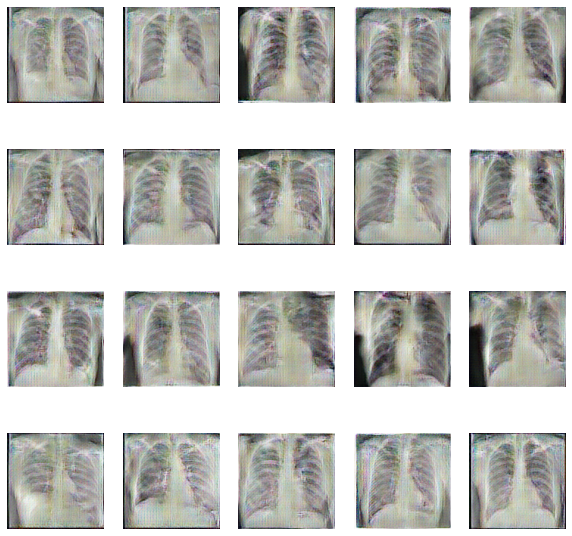

Epoch: 4001/5000, Loss: [D_real = 0.058, D_fake = 0.358, G = 7.890], time: 2.61sec
Epoch: 4002/5000, Loss: [D_real = 0.004, D_fake = 0.079, G = 6.845], time: 2.61sec
Epoch: 4003/5000, Loss: [D_real = 0.066, D_fake = 0.035, G = 6.123], time: 2.61sec
Epoch: 4004/5000, Loss: [D_real = 0.065, D_fake = 0.035, G = 7.584], time: 2.61sec
Epoch: 4005/5000, Loss: [D_real = 0.017, D_fake = 0.065, G = 8.953], time: 2.61sec
Epoch: 4006/5000, Loss: [D_real = 0.039, D_fake = 0.075, G = 8.259], time: 2.61sec
Epoch: 4007/5000, Loss: [D_real = 0.007, D_fake = 0.044, G = 7.535], time: 2.61sec
Epoch: 4008/5000, Loss: [D_real = 0.039, D_fake = 0.015, G = 7.678], time: 2.61sec
Epoch: 4009/5000, Loss: [D_real = 0.010, D_fake = 0.025, G = 7.125], time: 2.61sec
Epoch: 4010/5000, Loss: [D_real = 0.041, D_fake = 0.041, G = 8.913], time: 2.61sec
Epoch: 4011/5000, Loss: [D_real = 0.069, D_fake = 0.069, G = 7.373], time: 2.61sec
Epoch: 4012/5000, Loss: [D_real = 0.068, D_fake = 0.025, G = 6.302], time: 2.61sec
Epoc

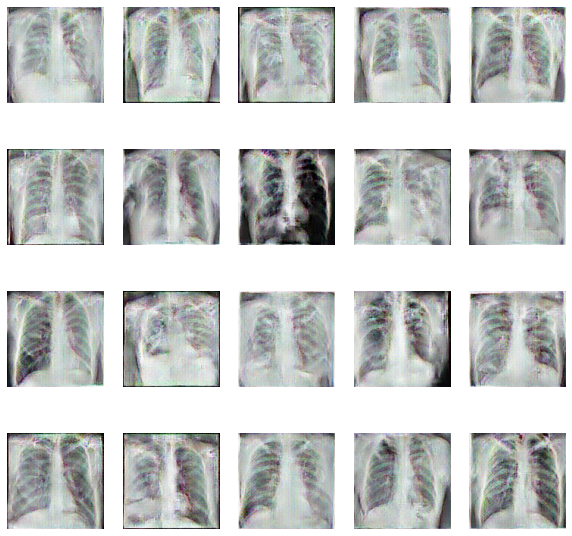

Epoch: 4501/5000, Loss: [D_real = 0.015, D_fake = 0.017, G = 7.415], time: 2.61sec
Epoch: 4502/5000, Loss: [D_real = 0.006, D_fake = 0.024, G = 7.949], time: 2.61sec
Epoch: 4503/5000, Loss: [D_real = 0.011, D_fake = 0.012, G = 7.303], time: 2.62sec
Epoch: 4504/5000, Loss: [D_real = 0.027, D_fake = 0.010, G = 6.572], time: 2.61sec
Epoch: 4505/5000, Loss: [D_real = 0.007, D_fake = 0.008, G = 7.276], time: 2.61sec
Epoch: 4506/5000, Loss: [D_real = 0.002, D_fake = 0.081, G = 9.776], time: 2.61sec
Epoch: 4507/5000, Loss: [D_real = 0.010, D_fake = 0.018, G = 7.002], time: 2.61sec
Epoch: 4508/5000, Loss: [D_real = 0.014, D_fake = 0.007, G = 6.822], time: 2.6sec
Epoch: 4509/5000, Loss: [D_real = 0.012, D_fake = 0.014, G = 7.320], time: 2.61sec
Epoch: 4510/5000, Loss: [D_real = 0.003, D_fake = 0.009, G = 7.459], time: 2.61sec
Epoch: 4511/5000, Loss: [D_real = 0.005, D_fake = 0.022, G = 8.388], time: 2.61sec
Epoch: 4512/5000, Loss: [D_real = 0.011, D_fake = 0.036, G = 8.972], time: 2.61sec
Epoch

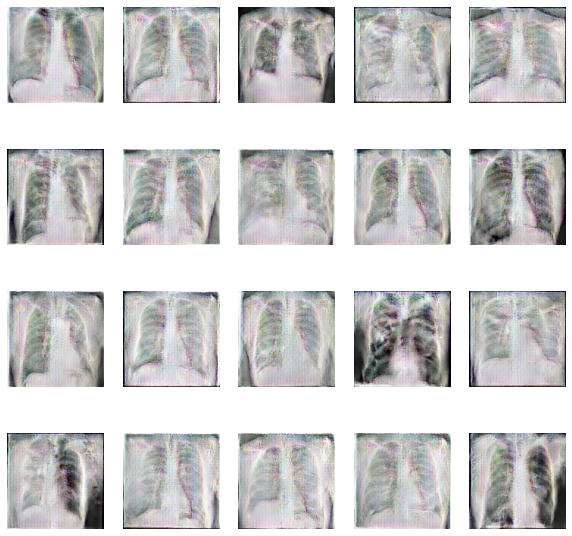

Total time for training 5000 epochs is 3h 38min 1.91sec sec


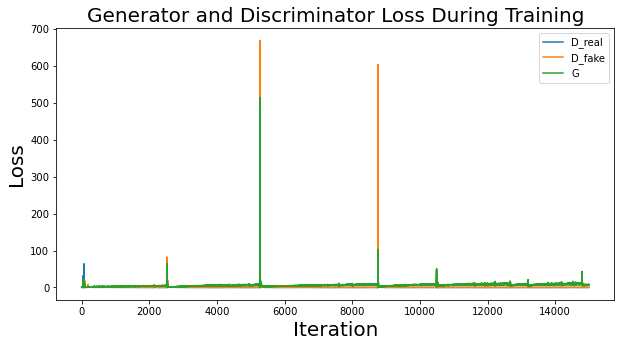

In [ ]:
# train model
train(generator, discriminator, gan, X_tb, latent_dim, n_epochs=n_epoch, n_batch=batch_size, start_epoch=0)

In [ ]:
fake_path = glob.glob('../working/image_at_epoch*.png')
fake_imgs = get_data(sorted(fake_path), rand_shuffle=False)

Processing index 00000 of 00010 ==> 000%
Processing index 00001 of 00010 ==> 010%
Processing index 00002 of 00010 ==> 020%
Processing index 00003 of 00010 ==> 030%
Processing index 00004 of 00010 ==> 040%
Processing index 00005 of 00010 ==> 050%
Processing index 00006 of 00010 ==> 060%
Processing index 00007 of 00010 ==> 070%
Processing index 00008 of 00010 ==> 080%
Processing index 00009 of 00010 ==> 090%
Hey! the calculations are done in 0.19sec


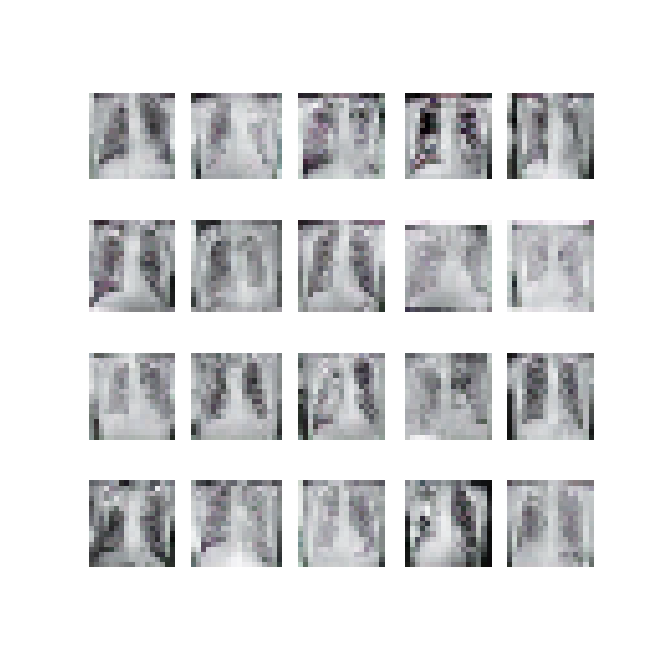

In [ ]:
fake_transp = [np.transpose(fake_imgs[i,:,:]) for i in range(fake_imgs.shape[0])]

fig = plt.figure(figsize=(12,12))
plt.axis("off")
imgs = [[plt.imshow(np.transpose(i,(2,1,0)), animated=True)] for i in fake_transp]
ani = animation.ArtistAnimation(fig, imgs, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# use the generator to generate n fake
def XRayFakeGenerator(g_model=generator, latent_dim =100, n_samples=100, show_gen=False):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)

    # Show the generated images
    if show_gen and n_samples<=30:
        ncols = 5
        nrows = int(n_samples/ncols)
        plt.figure(figsize=(12,10))
        for idx in range(nrows*ncols):
            plt.subplot(nrows, ncols, idx+1)
            plt.imshow(X[idx,:,:]); plt.axis('off')
        plt.show();
    return X

XRay_fake = XRayFakeGenerator(generator, n_samples=20)

In [ ]:
# SAVE TO ZIP FILE
import zipfile
output_path = zipfile.PyZipFile('../working/XRayNormalFake3.zip', mode='w')

XRay_generated = XRayFakeGenerator(n_samples=3000)
for idx in range(XRay_generated.shape[0]):
    img_XRayFake  = XRay_generated[idx,:,:]
    name_XRayFake = 'XRay_generated {:04d}.png'.format(idx)
    imageio.imwrite(name_XRayFake, img_XRayFake)

    output_path.write(name_XRayFake)
    os.remove(name_XRayFake)
output_path.close()